# Imports

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Constants

In [8]:
# Set the classes
classes = ('A', 'B', 'C', 'D', 'E')
# GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Labels
labels = {
    0 : 'A',
    1 : 'B',
    2 : 'C',
    3 : 'D',
    4 : 'E',
}

ROOT_DIR='/content'
TESTING_PATH = '/content/test/testing'

# Homebrewed Functions

In [9]:
def display_sample_image(imageloader, n=1):
    """Display a sample of the images in the given image loader"""
    plt.rcParams["figure.figsize"] = (10, 10)

    def _imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    for _ in range(n):
        # get some random images
        dataiter = iter(imageloader)
        images, labels = next(dataiter)

        # show images
        _imshow(torchvision.utils.make_grid(images))
        # print labels
        print(" ".join("%12s" % classes[labels[j]] for j in range(len(images))))


def plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption):
    """Plot the accuracy and loss"""
    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification Accuracy vs Epoch: {}".format(caption))

    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

    return


def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def save_model(net, PATH=f"{ROOT_DIR}/models/", name="asl_cnn.pth"):
    """Function to save the model"""
    torch.save(net.state_dict(), PATH + name)



## Train & Validate

In [10]:
def train(device=torch.device("cpu"), scheduler=None):
    """Function to train the model"""
    net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Calcualte accuracy
        _, predicted = torch.max(outputs.data.detach().cpu(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()

    training_loss.append(running_loss / i)
    training_acc.append(100.0 * correct / total)

    return running_loss


def validation(val_loader, device=torch.device("cpu"), verbose=False):
    actual = []
    pred = []

    file_name = []
    
    correct = 0
    total = 0
    running_loss = 0.0
    net.eval()

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))

            loss = criterion(outputs, labels.to(device))
            running_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.detach().cpu(), 1)
            fname, _ = test_loader.dataset.samples[i]
            file_name.append(fname.split('/')[-1])

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # collect the correct predictions for each class
            for label, prediction in zip(labels, predicted):
                if verbose:
                    actual.append(label.item())
                    pred.append(prediction.item())
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    if verbose:
        print("==" * 30)
        print(f"Accuracy of the network on the test images: {100 * correct / total}%")
        print("==" * 30)
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        print("==" * 30)
        plot_confusion_matrix(actual, pred)
        print(f"Loss: {running_loss / len(val_loader)}")

    if not verbose:
        val_acc.append(100.0 * correct / total)
        val_loss.append(running_loss / len(val_loader))

    results = pd.DataFrame(zip(file_name, pred), columns=['Filename', 'Predicted_label'])

    return results

## Load Data

In [11]:
def load_data(test_path, batch_size=32):
    # --------------------------------------------------------------------------------------------------
    # Set up transformer to normalize and transform the data
    # --------------------------------------------------------------------------------------------------
    test_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop((500, 500), scale=(0.8, 1.0), 
                    ratio=(0.9, 1.1)),
            transforms.ToTensor(), 
        ]
    )

    # --------------------------------------------------------------------------------------------------
    # Create the training and test datasets as well as the data loaders
    # --------------------------------------------------------------------------------------------------
    # Data Sets
    test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

    # Data Loaders
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                              shuffle=False, drop_last=False, num_workers=2)
    print(f"Successfully loaded images\nBatch size: {batch_size}")
    return test_loader

# Download Test Images

In [12]:
# Prepare dir
!mkdir /content/test/

# Fetch
!wget https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/images/testing.zip -O /content/test/testing.zip

# Unzip
!unzip /content/test/testing.zip -d /content/test

--2022-12-18 05:33:23--  https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/images/testing.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/images/testing.zip [following]
--2022-12-18 05:33:23--  https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/images/testing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100411 (98K) [application/zip]
Saving to: ‘/content/test/testing.zip’

/content/test/testi 100%[===================>]  98.06K  --.-KB/s    in 0.01s   

2022-12

# Download Model

In [5]:
%%capture
!pip install --upgrade --no-cache-dir gdown

In [6]:
!gdown --id 1ZJ07ze2xowqj25wQIDSUgRTX-DeKLJfk --output "alexnet_model.pth"

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZJ07ze2xowqj25wQIDSUgRTX-DeKLJfk
To: /content/alexnet_model.pth
100% 228M/228M [00:03<00:00, 67.2MB/s]


In [ ]:
# Fetch
# !wget https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/models/sgd_wd_tuned_asl_cnn.pth -O alexnet_model.pth

--2022-12-17 23:08:36--  https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/models/sgd_wd_tuned_asl_cnn.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/models/sgd_wd_tuned_asl_cnn.pth [following]
--2022-12-17 23:08:37--  https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/models/sgd_wd_tuned_asl_cnn.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16696148 (16M) [application/octet-stream]
Saving to: ‘best_model.pth’

best_model.pth      100%[===================>]  1

# Testing

## Load Images

In [13]:
test_loader = load_data(TESTING_PATH, batch_size=1)

Successfully loaded images
Batch size: 1


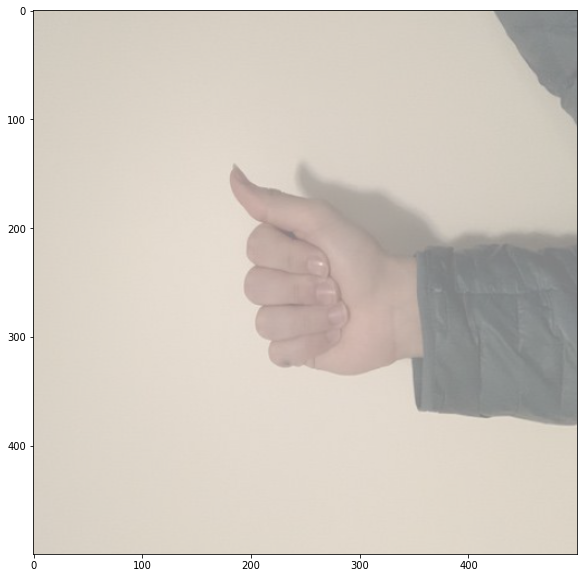

           A


In [14]:
display_sample_image(test_loader)

## Load Model

In [15]:
PATH = f'{ROOT_DIR}/alexnet_model.pth'

net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# NOTE: We have to change the last layer to have an output of 5 as we only have 5 classes.
net.classifier[6] = nn.Linear(4096, 5)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=0.9)

net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
# net.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

<All keys matched successfully>

## Evaluate

Accuracy of the network on the test images: 100.0%
Accuracy for class A     is: 100.0 %
Accuracy for class B     is: 100.0 %
Accuracy for class C     is: 100.0 %
Accuracy for class D     is: 100.0 %
Accuracy for class E     is: 100.0 %


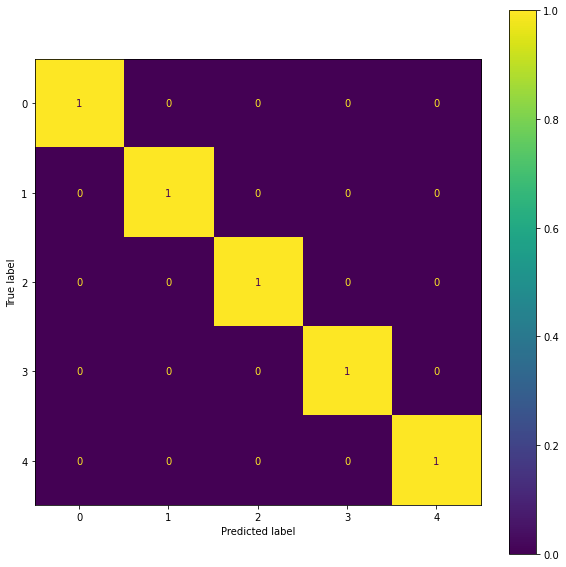

Loss: 0.16823318684473634


In [16]:
predicted = validation(test_loader, device=device, verbose=True)

In [17]:
predicted

,Filename,Predicted_label
0,R.A.A01.jpg,0
1,R.A.B01.jpg,1
2,R.A.C01.jpg,2
3,R.A.D01.jpg,3
4,R.A.E01.jpg,4


# Export Results

In [18]:
predicted['Predicted_label'] = predicted['Predicted_label'].map(labels)
predicted

,Filename,Predicted_label
0,R.A.A01.jpg,A
1,R.A.B01.jpg,B
2,R.A.C01.jpg,C
3,R.A.D01.jpg,D
4,R.A.E01.jpg,E


In [ ]:
predicted.to_csv('result.csv', index=False)